In [1]:
import torchtext
from torchtext.vocab import Vectors, GloVe
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from submission.models import *
from submission.helpers import *
from evaluation import *

In [2]:
# Our input $x$
TEXT = torchtext.data.Field()
    
# Our labels $y$
LABEL = torchtext.data.Field(sequential=False)


train, val, test = torchtext.datasets.SST.splits(
    TEXT, LABEL,
    filter_pred=lambda ex: ex.label != 'neutral')

# Build vocab
TEXT.build_vocab(train)
LABEL.build_vocab(train)

train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
(train, val, test), batch_size=11, device=-1)

# Build the vocabulary with word embeddings
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
TEXT.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

# Multinomial NB

In [3]:
model = MultinomialNB(TEXT, LABEL)
model.train(train_iter)

0
100
200
300
400
500
600


In [4]:
evaluator = TextEvaluator(model)
evaluator.score(test_iter)

Iteration 0, predictions: [1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Iteration 100, predictions: [2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2]
Accuracy: 1500 1821 0.8237232289950577


# Log Reg

Iteration 0, loss: 1.106063
Iteration 100, loss: 0.625547
Iteration 200, loss: 0.581383
Iteration 300, loss: 0.591005
Iteration 400, loss: 0.631406
Iteration 500, loss: 0.596144
Iteration 600, loss: 0.487899
Iteration 700, loss: 0.437492
Iteration 800, loss: 0.474699
Iteration 900, loss: 0.621603


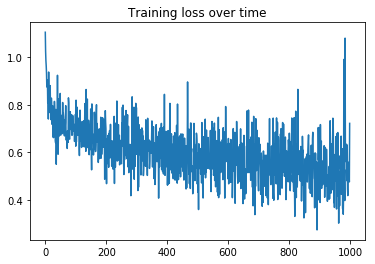

In [5]:
model = LogisticRegression(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL, model)
trainer.train(train_iter)

In [6]:
evaluator = TextEvaluator(model)
evaluator.score(test_iter)

Iteration 0, predictions: [2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2]
Iteration 100, predictions: [2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2]
Accuracy: 1319 1821 0.7243272926963207


# CBOW

Iteration 0, loss: 1.303189
Iteration 100, loss: 11.905661
Iteration 200, loss: 1.239030
Iteration 300, loss: 0.531637
Iteration 400, loss: 1.795287
Iteration 500, loss: 0.583758
Iteration 600, loss: 3.013718
Iteration 700, loss: 0.186613
Iteration 800, loss: 0.336711
Iteration 900, loss: 0.503474


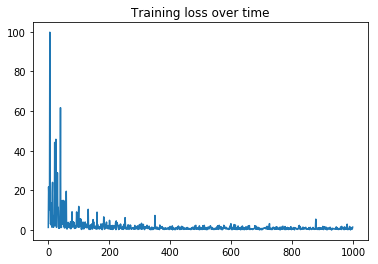

In [7]:
model = CBOW(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL, model)
trainer.train(train_iter)

In [8]:
evaluator = TextEvaluator(model)
evaluator.score(test_iter)

Iteration 0, predictions: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Iteration 100, predictions: [2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2]
Accuracy: 1310 1821 0.7193849533223503


# CNN

In [9]:
class CNN(nn.Module):
    def __init__(self, TEXT, LABEL):
        super(CNN, self).__init__()
        
        N = TEXT.vocab.vectors.size()[0]
        D = TEXT.vocab.vectors.size()[1]
        C = len(LABEL.vocab)
        in_channels = 1
        out_channels = 100
        kernel_sizes = [2,3] 
        
        self.embeddings = nn.Embedding(N, D)
        self.embeddings.weight = nn.Parameter(TEXT.vocab.vectors, requires_grad=True)
        
        # Linear layer
        self.linear = nn.Linear(TEXT.vocab.vectors.size()[1], len(LABEL.vocab))

        # List of convolutional layers
        self.convs1 = nn.ModuleList([nn.Conv2d(in_channels, out_channels, (K, D)) for K in kernel_sizes])

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(len(kernel_sizes)*out_channels, C)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, out_channels, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        x = self.embeddings(x)  # (N, W, D)

        x = x.unsqueeze(1)  # (N, in_channels, W, D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, out_channels, W), ...]*len(kernel_sizes)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, out_channels), ...]*len(kernel_sizes)
        x = torch.cat(x, 1)

        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = F.log_softmax(self.fc1(x), dim=1)  # (N, C)
        return logit

300
Iteration 0, loss: 0.999858
Iteration 100, loss: 0.628103
Iteration 200, loss: 0.704661
Iteration 300, loss: 0.522510
Iteration 400, loss: 0.525881
Iteration 500, loss: 0.179983
Iteration 600, loss: 0.426121
Iteration 700, loss: 0.767220
Iteration 800, loss: 0.621493
Iteration 900, loss: 0.717283
Iteration 1000, loss: 0.320259
Iteration 1100, loss: 0.409002
Iteration 1200, loss: 0.523681
Iteration 1300, loss: 0.428039
Iteration 1400, loss: 0.449271
Iteration 1500, loss: 0.212559
Iteration 1600, loss: 0.248804
Iteration 1700, loss: 0.653707
Iteration 1800, loss: 0.174198
Iteration 1900, loss: 0.208549
Iteration 2000, loss: 0.377991
Iteration 2100, loss: 0.205883
Iteration 2200, loss: 0.365724
Iteration 2300, loss: 0.133578
Iteration 2400, loss: 0.155792
Iteration 2500, loss: 0.547009
Iteration 2600, loss: 0.167726
Iteration 2700, loss: 0.074108
Iteration 2800, loss: 0.090898
Iteration 2900, loss: 0.161618
Iteration 3000, loss: 0.359065
Iteration 3100, loss: 0.210044
Iteration 3200, 

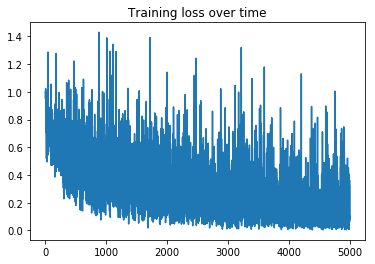

In [13]:
model = CNN(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL, model)
trainer.train(train_iter, num_iter=5000)

In [14]:
evaluator = TextEvaluator(model)
evaluator.score(test_iter)

Iteration 0, predictions: [2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1]
Iteration 100, predictions: [2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2]
Accuracy: 1433 1821 0.7869302580999451
